## Setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2024-11-17 14:37:58.819090: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.1


In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

import os
import kagglehub

# Input images

In [3]:
content_path = '/Users/Anelya/Desktop/courses/dl/project/content3.jpg'
style_1_path = '/Users/Anelya/Desktop/courses/dl/project/style2.jpg'
style_2_path = '/Users/Anelya/Desktop/courses/dl/project/style3.jpg'


### Pre-process the inputs

* The content image and the style image must be RGB images with pixel values being float32 numbers between [0..1].
* The style image size must be (1, 256, 256, 3). We central crop the image and resize it.
* The content image must be (1, 384, 384, 3). We central crop the image and resize it.

In [4]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
    img = tf.io.read_file(path_to_img)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    
    return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
    # Resize the image so that the shorter dimension becomes 256px.
    shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
    short_dim = min(shape)
    scale = target_dim / short_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)

    # Central crop the image.
    image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

    return image

In [5]:
# Preprocess the input images.
preprocessed_content_image = preprocess_image(load_img(content_path), 384)
preprocessed_style_1_image = preprocess_image(load_img(style_1_path), 256)
preprocessed_style_2_image = preprocess_image(load_img(style_2_path), 256)

print('Style 1 Image Shape:', preprocessed_style_1_image.shape)
print('Style 2 Image Shape:', preprocessed_style_2_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

Style 1 Image Shape: (1, 256, 256, 3)
Style 2 Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


### Visualize the inputs

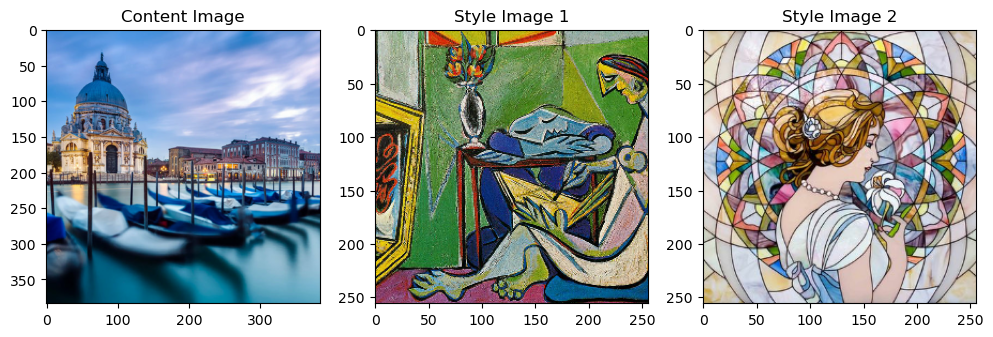

In [6]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    
    plt.imshow(image)
    
    if title:
        plt.title(title)

plt.subplot(1, 3, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 3, 2)
imshow(preprocessed_style_1_image, 'Style Image 1')

plt.subplot(1, 3, 3)
imshow(preprocessed_style_2_image, 'Style Image 2')

## Load pre-trained tflite models

In [7]:
full_path_predict = 'tfLite/256-int8-prediction/1/1.tflite'
full_path_transform = 'tfLite/256-int8-transfer/1/1.tflite'

In [8]:
full_path_transform

'tfLite/256-int8-transfer/1/1.tflite'

In [9]:
full_path_predict

'tfLite/256-int8-prediction/1/1.tflite'

### Style prediction

In [10]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
    # Load the model.
    interpreter = tf.lite.Interpreter(model_path=full_path_predict)

    # Set model input.
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

    # Calculate style bottleneck.
    interpreter.invoke()
    style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

    return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
style_1_bottleneck = run_style_predict(preprocessed_style_1_image)
style_2_bottleneck = run_style_predict(preprocessed_style_2_image)
print('Style 1 Bottleneck Shape:', style_1_bottleneck.shape)
print('Style 2 Bottleneck Shape:', style_2_bottleneck.shape)

Style 1 Bottleneck Shape: (1, 1, 1, 100)
Style 2 Bottleneck Shape: (1, 1, 1, 100)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Style transform

In [11]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
    # Load the model.
    interpreter = tf.lite.Interpreter(model_path=full_path_transform)

    # Set model input.
    input_details = interpreter.get_input_details()
    interpreter.allocate_tensors()

    # Set model inputs.
    interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
    interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
    interpreter.invoke()

    # Transform content image.
    stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

    return stylized_image

# Combine two styles 

In [12]:
def fourier_transform(tensor):
    # Apply Fourier Transform
    fft = tf.signal.fft2d(tf.cast(tensor, tf.complex64))
    return fft

def inverse_fourier_transform(tensor):
    # Inverse Fourier Transform
    ifft = tf.signal.ifft2d(tensor)
    return tf.cast(ifft, tf.float32)

# Fourier transform of bottlenecks
fft_style_1 = fourier_transform(style_1_bottleneck)
fft_style_2 = fourier_transform(style_2_bottleneck)

# Combine frequency components
fft_combined = 0.8 * fft_style_1 + 0.2 * fft_style_2

# Inverse Fourier transform
style_bottleneck_fft = inverse_fourier_transform(fft_combined)

# Stylize content
stylized_image_fft = run_style_transform(style_bottleneck_fft, preprocessed_content_image)


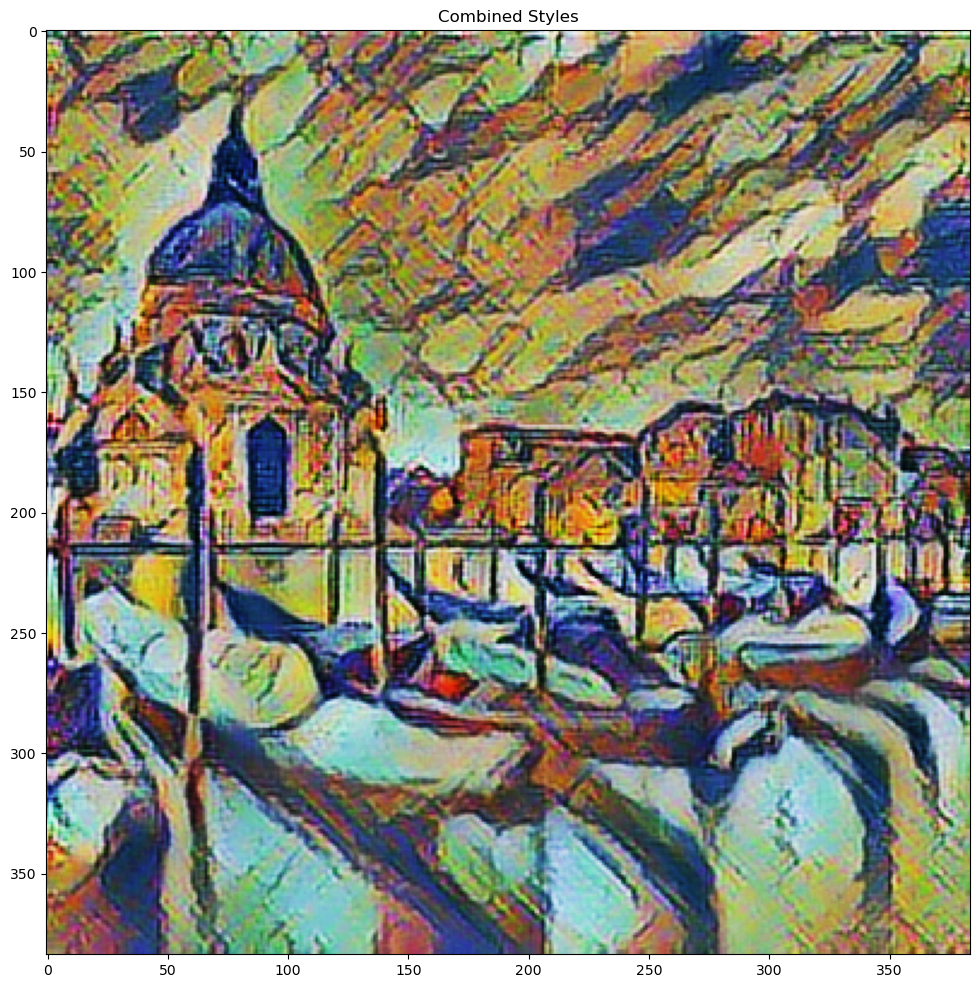

In [13]:
imshow(stylized_image_fft, 'Combined Styles')